In [19]:
import mediapipe as mp
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Detections

In [5]:
cap = cv.VideoCapture("./data/infantvideo.mp4")
with mp_pose.Pose(min_detection_confidence=0.5,min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        # Recolor image to RGB
        image = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        image.flags.writeable = False
        # Make detection
        results = pose.process(image)
        #Recolor back to BGR
        image.flags.writeable = True
        image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )
        cv.imshow('Mediapipe Feed', image)
        if cv.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()
        

C:\PERSONAL\advanced_CV\vision\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


# Determining Joints
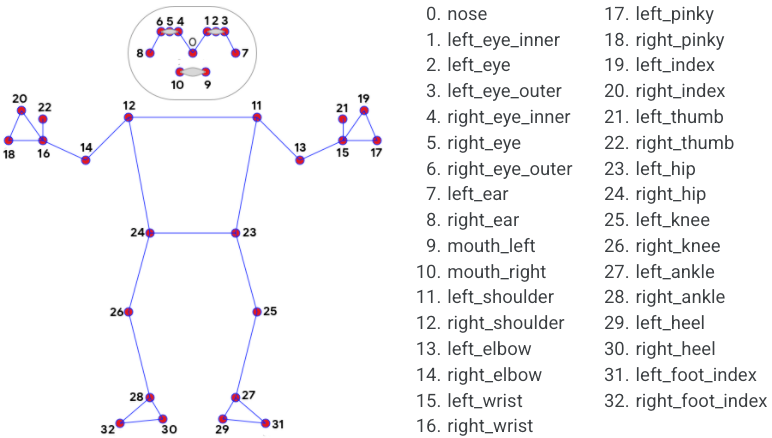

## Joint Orientation

In [10]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Number of bins for the histogram (e.g., 8 bins representing 45-degree intervals)
num_bins = 8
bin_angles = np.linspace(0, 360, num_bins + 1)  # 0, 45, 90, ..., 360 degrees
bin_counts = np.zeros(num_bins)  # To count occurrences in each bin

# Function to determine which bin an angle belongs to
def get_bin_index(angle_deg):
    # Place the angle into the appropriate bin
    bin_index = np.digitize(angle_deg, bin_angles) - 1  # -1 because bins are 1-indexed by default
    if bin_index == num_bins:  # Handle case where angle is exactly 360 degrees
        bin_index = 0
    return bin_index

# Setup video capture
cap = cv.VideoCapture("./data/infantvideo.mp4")
print("Number of frames:", int(cap.get(cv.CAP_PROP_FRAME_COUNT)))

# Setup Mediapipe Pose instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()

        # Check if the frame was successfully read (False when the video ends)
        if not ret:
            print("End of video or error.")
            break
        
        # Recolor image to RGB
        image = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Make detections
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            # Get the current frame number
            current_frame = int(cap.get(cv.CAP_PROP_POS_FRAMES)) - 1
            
            # Calculate bone vector (left elbow to left shoulder)
            x = round((landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x - landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x), 5)
            y = round((landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y - landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y), 5)
            vector = np.array([x, y])

            # Normalize the vector
            magnitude = np.linalg.norm(vector)
            if magnitude > 0:
                norm_vector = vector / magnitude
            else:
                norm_vector = vector  # Avoid division by zero
            
            # Define the reference unit vector (e.g., vertical direction)
            reference_vector = np.array([0, 1])  # Unit vector pointing straight up
            
            # Calculate the dot product
            dot_product = np.dot(norm_vector, reference_vector)
            dot_product = np.clip(dot_product, -1.0, 1.0)  # Ensure value is in [-1, 1] for arccos
            
            # Calculate the angle in radians and degrees
            angle_rad = np.arccos(dot_product)
            angle_deg = np.degrees(angle_rad)
            
            # Adjust the angle based on the quadrant
            if norm_vector[0] < 0:  # If x is negative, adjust for the correct angle in the third and fourth quadrants
                angle_deg = 360 - angle_deg
            
            print(f"Frame {current_frame}: Angle (degrees) = {angle_deg}")

            # Determine the appropriate bin for the calculated angle
            bin_index = get_bin_index(angle_deg)
            bin_counts[bin_index] += 1  # Increment the count for the appropriate bin
            
            print(f"Assigned to Bin {bin_index}, Current Bin Counts: {bin_counts}")
        
        except Exception as e:
            print(f"Error processing frame {current_frame}: {e}")
            pass
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
        
        cv.imshow('Mediapipe Feed', image)
        
        if cv.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()

# Print final bin counts after processing the video
print("Final Bin Counts:", bin_counts)

Number of frames: 703
Frame 0: Angle (degrees) = 262.20697578119575
Assigned to Bin 5, Current Bin Counts: [0. 0. 0. 0. 0. 1. 0. 0.]
Frame 1: Angle (degrees) = 262.7956925592959
Assigned to Bin 5, Current Bin Counts: [0. 0. 0. 0. 0. 2. 0. 0.]
Frame 2: Angle (degrees) = 264.49421739398736
Assigned to Bin 5, Current Bin Counts: [0. 0. 0. 0. 0. 3. 0. 0.]
Frame 3: Angle (degrees) = 264.0923426033941
Assigned to Bin 5, Current Bin Counts: [0. 0. 0. 0. 0. 4. 0. 0.]
Frame 4: Angle (degrees) = 264.5106781626623
Assigned to Bin 5, Current Bin Counts: [0. 0. 0. 0. 0. 5. 0. 0.]
Frame 5: Angle (degrees) = 262.370057245467
Assigned to Bin 5, Current Bin Counts: [0. 0. 0. 0. 0. 6. 0. 0.]
Frame 6: Angle (degrees) = 263.9125686769811
Assigned to Bin 5, Current Bin Counts: [0. 0. 0. 0. 0. 7. 0. 0.]
Frame 7: Angle (degrees) = 263.91087848469454
Assigned to Bin 5, Current Bin Counts: [0. 0. 0. 0. 0. 8. 0. 0.]
Frame 8: Angle (degrees) = 261.7464919182863
Assigned to Bin 5, Current Bin Counts: [0. 0. 0. 0.

## Joint Displacement

Number of frames: 703
Frame 0: Right shoulder to elbow Angle = 82.21
Assigned to Bin 1 for Right shoulder to elbow, Current Bin Counts: [0. 1. 0. 0. 0. 0. 0. 0.]
Frame 0: Right elbow to wrist Angle = 58.93
Assigned to Bin 1 for Right elbow to wrist, Current Bin Counts: [0. 1. 0. 0. 0. 0. 0. 0.]
Frame 0: Left shoulder to elbow Angle = 243.80
Assigned to Bin 5 for Left shoulder to elbow, Current Bin Counts: [0. 0. 0. 0. 0. 1. 0. 0.]
Frame 0: Left elbow to wrist Angle = 20.55
Assigned to Bin 0 for Left elbow to wrist, Current Bin Counts: [1. 0. 0. 0. 0. 0. 0. 0.]
Frame 0: Right hip to knee Angle = 171.54
Assigned to Bin 3 for Right hip to knee, Current Bin Counts: [0. 0. 0. 1. 0. 0. 0. 0.]
Frame 0: Right knee to ankle Angle = 232.16
Assigned to Bin 5 for Right knee to ankle, Current Bin Counts: [0. 0. 0. 0. 0. 1. 0. 0.]
Frame 0: Left hip to knee Angle = 189.68
Assigned to Bin 4 for Left hip to knee, Current Bin Counts: [0. 0. 0. 0. 1. 0. 0. 0.]
Frame 0: Left knee to ankle Angle = 181.74
A

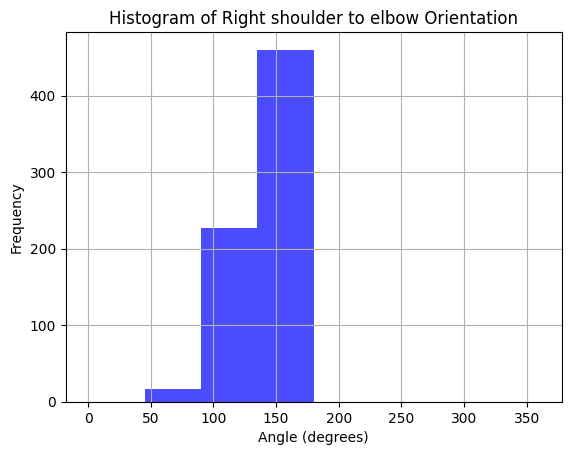

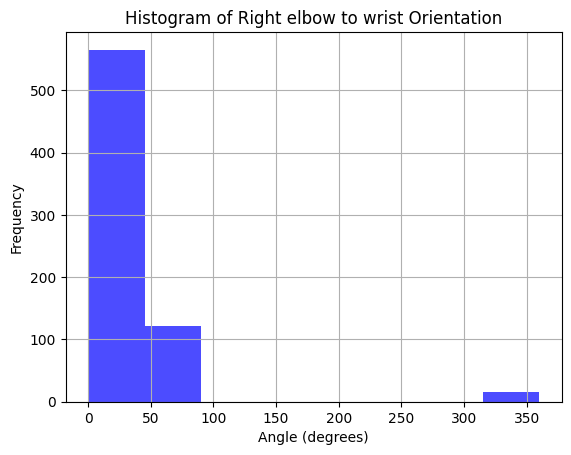

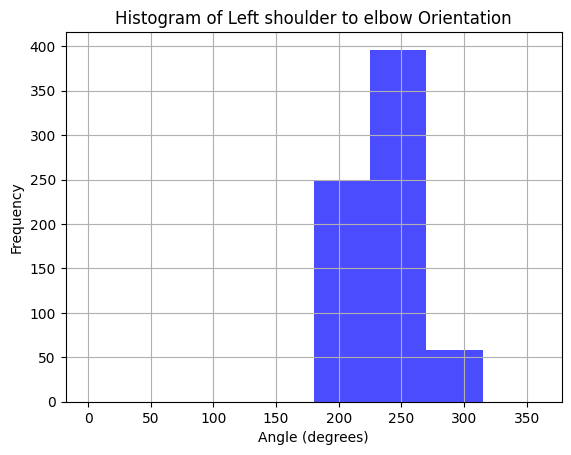

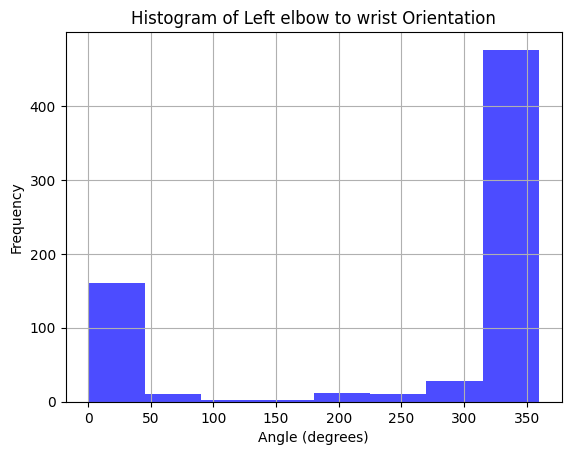

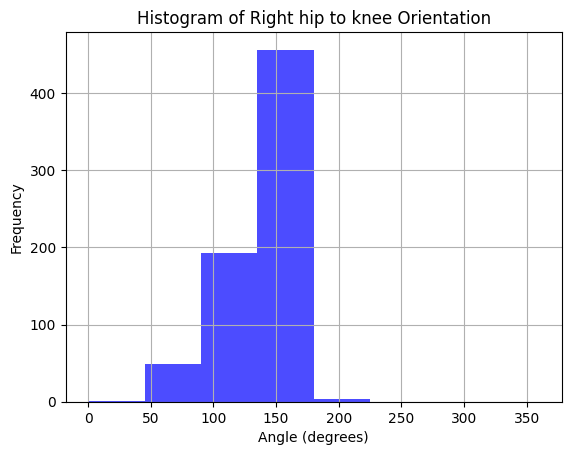

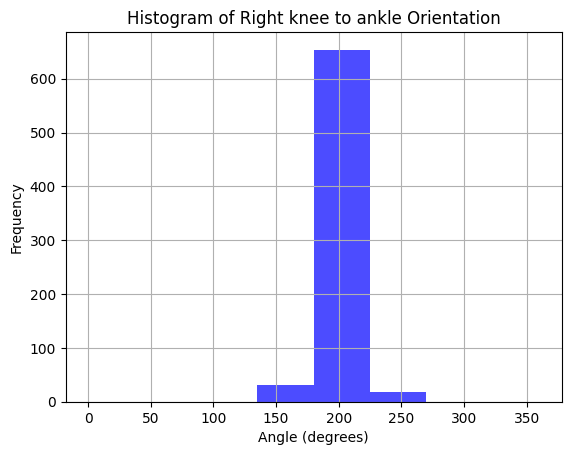

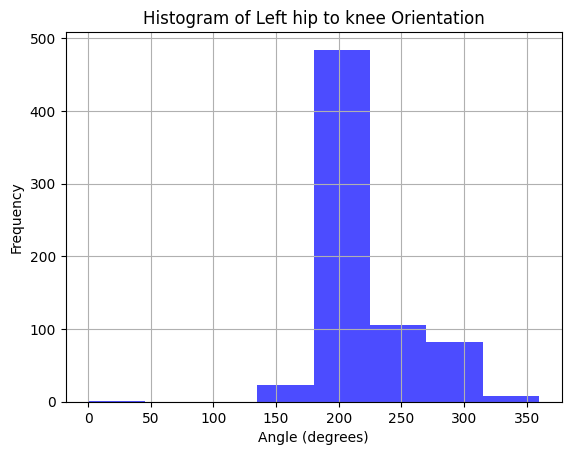

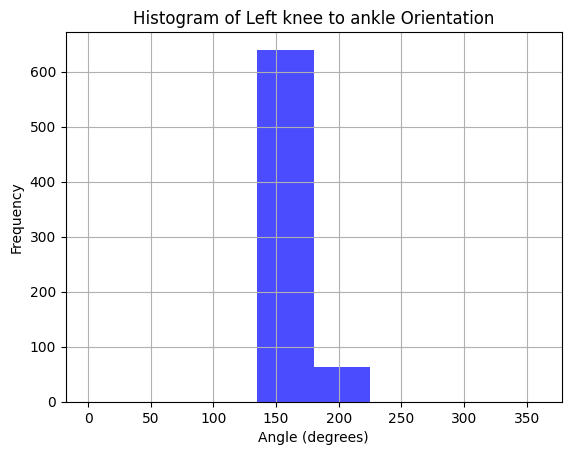

Final Bin Counts for Right shoulder to elbow: [  0.  16. 227. 460.   0.   0.   0.   0.]
Final Bin Counts for Right elbow to wrist: [565. 122.   0.   0.   0.   0.   0.  16.]
Final Bin Counts for Left shoulder to elbow: [  0.   0.   0.   0. 249. 396.  58.   0.]
Final Bin Counts for Left elbow to wrist: [160.  11.   3.   3.  12.  10.  28. 476.]
Final Bin Counts for Right hip to knee: [  1.  49. 193. 456.   4.   0.   0.   0.]
Final Bin Counts for Right knee to ankle: [  0.   0.   0.  31. 654.  18.   0.   0.]
Final Bin Counts for Left hip to knee: [  1.   0.   0.  23. 484. 105.  82.   8.]
Final Bin Counts for Left knee to ankle: [  0.   0.   0. 640.  63.   0.   0.   0.]


In [18]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Number of bins for the histogram (e.g., 8 bins representing 45-degree intervals)
num_bins = 8
bin_angles = np.linspace(0, 360, num_bins + 1)  # 0, 45, 90, ..., 360 degrees

# Dictionary to store bin counts for each joint pair
bin_counts = {
    'right_shoulder_to_elbow': np.zeros(num_bins),
    'right_elbow_to_wrist': np.zeros(num_bins),
    'left_shoulder_to_elbow': np.zeros(num_bins),
    'left_elbow_to_wrist': np.zeros(num_bins),
    'right_hip_to_knee': np.zeros(num_bins),
    'right_knee_to_ankle': np.zeros(num_bins),
    'left_hip_to_knee': np.zeros(num_bins),
    'left_knee_to_ankle': np.zeros(num_bins)
}

# Function to determine which bin an angle belongs to
def get_bin_index(angle_deg):
    bin_index = np.digitize(angle_deg, bin_angles) - 1  # -1 because bins are 1-indexed by default
    if bin_index == num_bins:  # Handle case where angle is exactly 360 degrees
        bin_index = 0
    return bin_index

# Function to calculate the orientation angle between two joints
def calculate_angle(landmarks, joint1, joint2):
    x = round((landmarks[joint1].x - landmarks[joint2].x), 5)
    y = round((landmarks[joint1].y - landmarks[joint2].y), 5)
    vector = np.array([x, y])

    # Normalize the vector
    magnitude = np.linalg.norm(vector)
    if magnitude > 0:
        norm_vector = vector / magnitude
    else:
        norm_vector = vector  # Avoid division by zero

    # Define the reference unit vector (e.g., vertical direction)
    reference_vector = np.array([0, 1])  # Unit vector pointing straight up

    # Calculate the dot product
    dot_product = np.dot(norm_vector, reference_vector)
    dot_product = np.clip(dot_product, -1.0, 1.0)  # Ensure value is in [-1, 1] for arccos

    # Calculate the angle in radians and degrees
    angle_rad = np.arccos(dot_product)
    angle_deg = np.degrees(angle_rad)

    # Adjust the angle based on the quadrant
    if norm_vector[0] < 0:  # If x is negative, adjust for the correct angle in the third and fourth quadrants
        angle_deg = 360 - angle_deg

    return angle_deg

# Setup video capture
cap = cv.VideoCapture("./data/infantvideo.mp4")
print("Number of frames:", int(cap.get(cv.CAP_PROP_FRAME_COUNT)))

# Setup Mediapipe Pose instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()

        # Check if the frame was successfully read (False when the video ends)
        if not ret:
            print("End of video or error.")
            break
        
        # Recolor image to RGB
        image = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Make detections
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            # Get the current frame number
            current_frame = int(cap.get(cv.CAP_PROP_POS_FRAMES)) - 1
            
            # Calculate orientations for all joint pairs
            joint_pairs = {
                'right_shoulder_to_elbow': (mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_ELBOW),
                'right_elbow_to_wrist': (mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_WRIST),
                'left_shoulder_to_elbow': (mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_ELBOW),
                'left_elbow_to_wrist': (mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_WRIST),
                'right_hip_to_knee': (mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_KNEE),
                'right_knee_to_ankle': (mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE),
                'left_hip_to_knee': (mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_KNEE),
                'left_knee_to_ankle': (mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE)
            }

            for joint_pair, (joint1, joint2) in joint_pairs.items():
                angle_deg = calculate_angle(landmarks, joint1.value, joint2.value)
                print(f"Frame {current_frame}: {joint_pair.replace('_', ' ').capitalize()} Angle = {angle_deg:.2f}")

                # Determine the appropriate bin for the calculated angle
                bin_index = get_bin_index(angle_deg)
                bin_counts[joint_pair][bin_index] += 1  # Increment the count for the appropriate bin

                print(f"Assigned to Bin {bin_index} for {joint_pair.replace('_', ' ').capitalize()}, Current Bin Counts: {bin_counts[joint_pair]}")

        except Exception as e:
            print(f"Error processing frame {current_frame}: {e}")
            pass
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
        
        cv.imshow('Mediapipe Feed', image)
        
        if cv.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()

# Plot histograms for each joint pair orientation
for joint_pair, counts in bin_counts.items():
    plt.figure()
    plt.bar(bin_angles[:-1], counts, width=360 / num_bins, align='edge', color='blue', alpha=0.7)
    plt.title(f'Histogram of {joint_pair.replace("_", " ").capitalize()} Orientation')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Frequency')
    plt.grid(True)
    # Optionally, save histograms to a file
    plt.savefig(f'./orientation/{joint_pair}_orientation_histogram.png')
    plt.show()


# Print final bin counts after processing the video
for joint_pair, counts in bin_counts.items():
    print(f"Final Bin Counts for {joint_pair.replace('_', ' ').capitalize()}: {counts}")


Number of frames: 703
Frame 1: Displacement of Right elbow = 0.00273
Frame 1: Displacement of Right wrist = 0.00017
Frame 1: Displacement of Left elbow = 0.00230
Frame 1: Displacement of Left wrist = 0.00781
Frame 1: Displacement of Right knee = 0.00545
Frame 1: Displacement of Right ankle = 0.02069
Frame 1: Displacement of Left knee = 0.00809
Frame 1: Displacement of Left ankle = 0.00297
Frame 2: Displacement of Right elbow = 0.00794
Frame 2: Displacement of Right wrist = 0.00155
Frame 2: Displacement of Left elbow = 0.00907
Frame 2: Displacement of Left wrist = 0.00301
Frame 2: Displacement of Right knee = 0.00445
Frame 2: Displacement of Right ankle = 0.01749
Frame 2: Displacement of Left knee = 0.00445
Frame 2: Displacement of Left ankle = 0.02800
Frame 3: Displacement of Right elbow = 0.00181
Frame 3: Displacement of Right wrist = 0.00017
Frame 3: Displacement of Left elbow = 0.00393
Frame 3: Displacement of Left wrist = 0.01164
Frame 3: Displacement of Right knee = 0.00413
Frame 

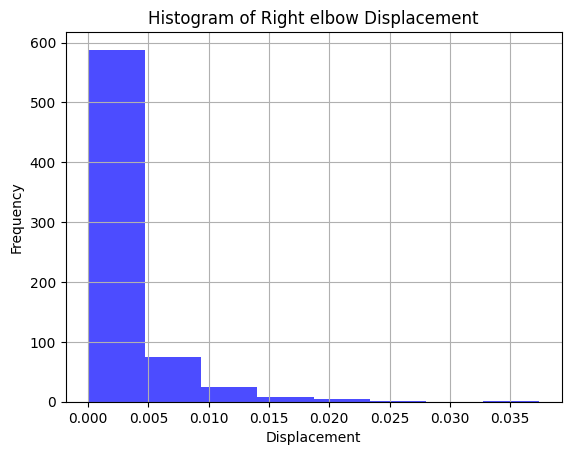

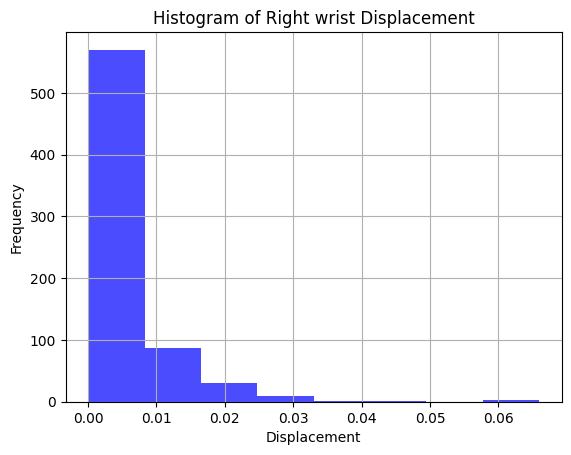

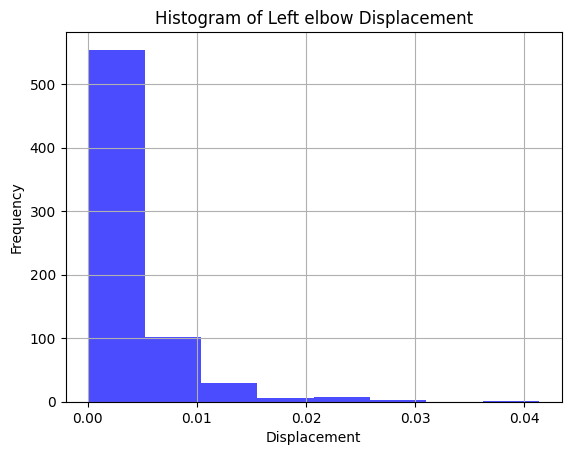

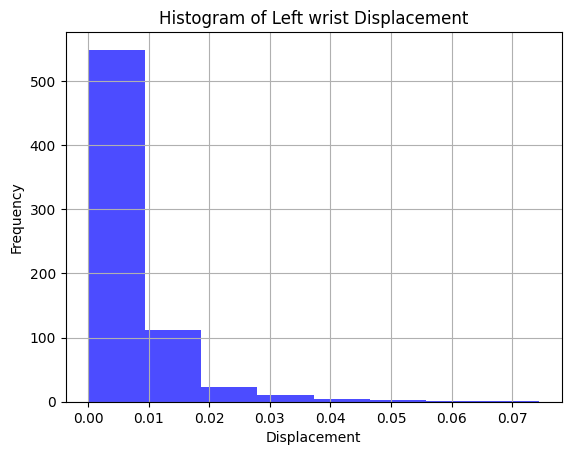

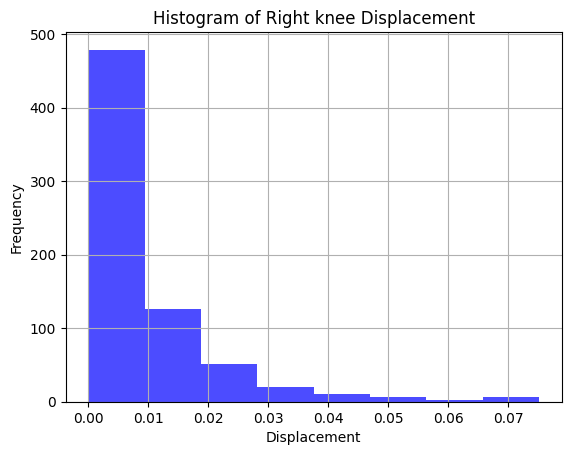

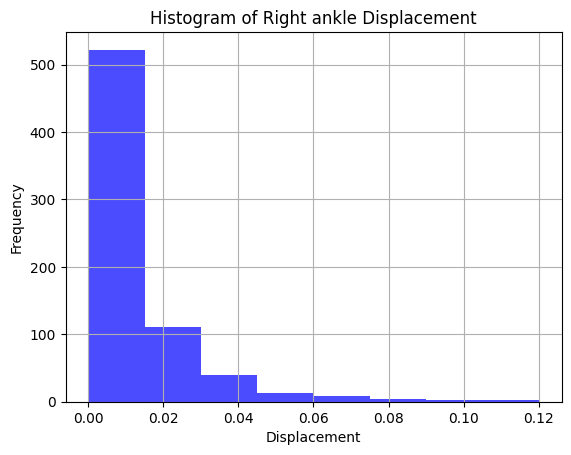

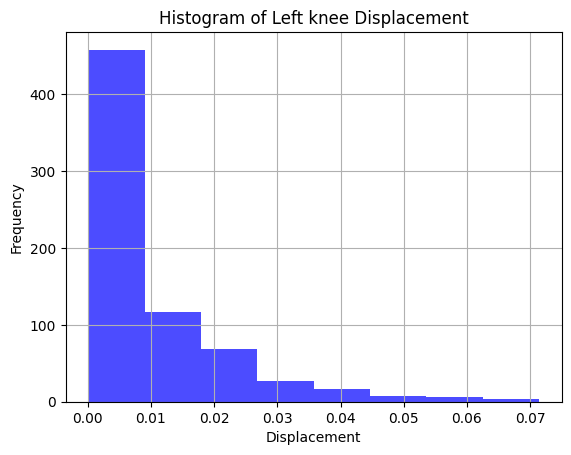

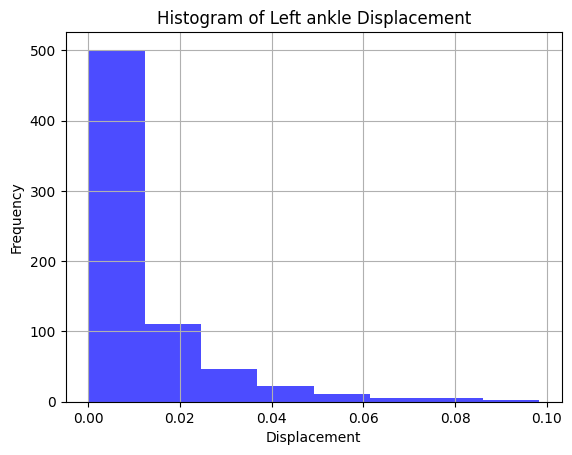

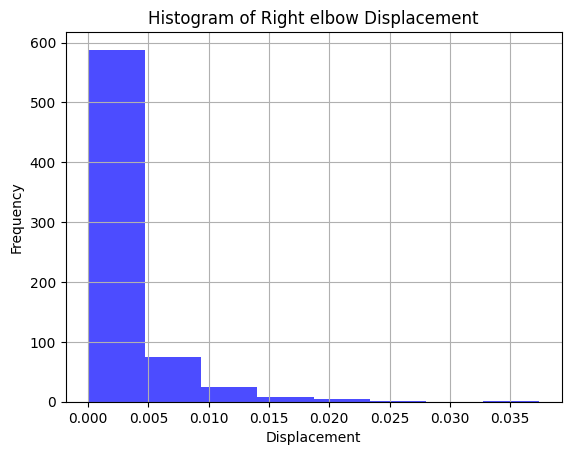

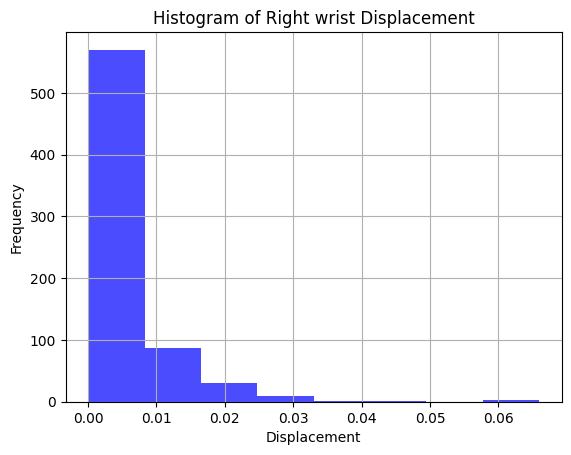

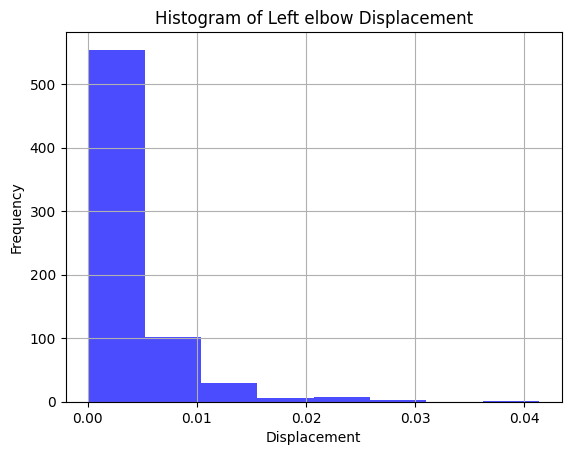

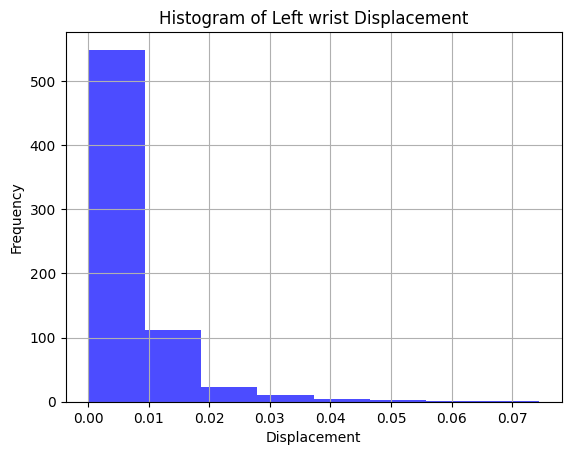

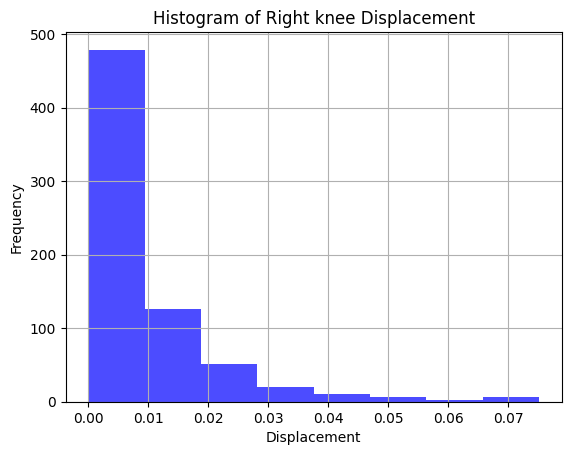

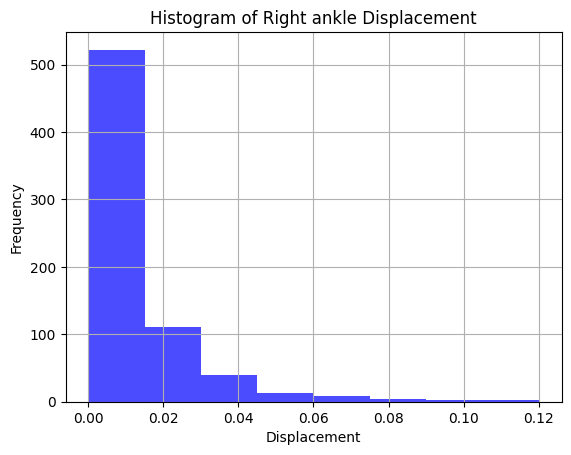

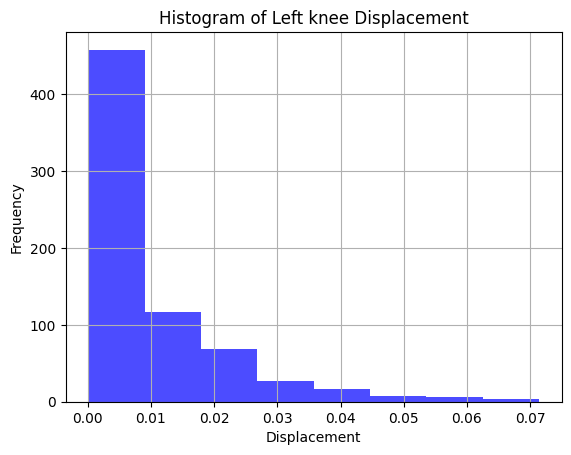

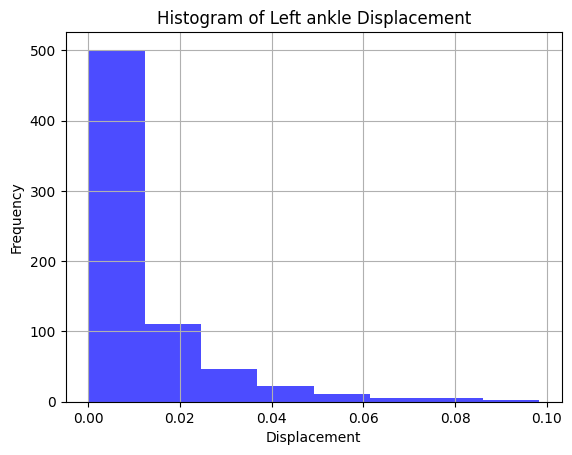

In [20]:
import numpy as np
import cv2 as cv
import mediapipe as mp
import matplotlib.pyplot as plt

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Setup video capture
cap = cv.VideoCapture("./data/infantvideo.mp4")
print("Number of frames:", int(cap.get(cv.CAP_PROP_FRAME_COUNT)))

# Initialize variables to store displacements
displacements = {
    'right_elbow': [],
    'right_wrist': [],
    'left_elbow': [],
    'left_wrist': [],
    'right_knee': [],
    'right_ankle': [],
    'left_knee': [],
    'left_ankle': []
}

# Initialize a dictionary to store the previous joint positions for displacement calculations
prev_landmarks = None

# Setup Mediapipe Pose instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()

        # Check if the frame was successfully read (False when the video ends)
        if not ret:
            print("End of video or error.")
            break
        
        # Recolor image to RGB
        image = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Make detections
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            current_frame = int(cap.get(cv.CAP_PROP_POS_FRAMES)) - 1
            
            # Calculate joint displacement for specific joints
            current_positions = {
                'right_elbow': np.array([landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,
                                         landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]),
                'right_wrist': np.array([landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,
                                         landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]),
                'left_elbow': np.array([landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                                        landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]),
                'left_wrist': np.array([landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,
                                        landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]),
                'right_knee': np.array([landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,
                                        landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]),
                'right_ankle': np.array([landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,
                                         landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]),
                'left_knee': np.array([landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,
                                       landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]),
                'left_ankle': np.array([landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,
                                        landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y])
            }
            
            # If previous landmarks exist, calculate displacement
            if prev_landmarks is not None:
                for joint in current_positions.keys():
                    displacement = np.linalg.norm(current_positions[joint] - prev_landmarks[joint])
                    displacements[joint].append(displacement)
                    print(f"Frame {current_frame}: Displacement of {joint.replace('_', ' ').capitalize()} = {displacement:.5f}")
            
            # Update previous landmarks for next frame
            prev_landmarks = current_positions

        except Exception as e:
            print(f"Error processing frame {current_frame}: {e}")
            pass

        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
        
        cv.imshow('Mediapipe Feed', image)
        
        if cv.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()

# Plot histograms for each joint displacement
for joint, displacement in displacements.items():
    plt.figure()
    plt.hist(displacement, bins=8, alpha=0.7, color='blue')
    plt.title(f'Histogram of {joint.replace("_", " ").capitalize()} Displacement')
    plt.xlabel('Displacement')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Save histograms to a file
for joint, displacement in displacements.items():
    plt.figure()
    plt.hist(displacement, bins=8, alpha=0.7, color='blue')
    plt.title(f'Histogram of {joint.replace("_", " ").capitalize()} Displacement')
    plt.xlabel('Displacement')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.savefig(f'./displacement/{joint}_displacement_histogram.png')


## Joint Displacement

Number of frames: 703
Frame 9: Displacement of Right elbow = 0.00807
Frame 9: Displacement of Right wrist = 0.00538
Frame 9: Displacement of Left elbow = 0.01947
Frame 9: Displacement of Left wrist = 0.03477
Frame 9: Displacement of Right knee = 0.02337
Frame 9: Displacement of Right ankle = 0.04674
Frame 9: Displacement of Left knee = 0.06089
Frame 9: Displacement of Left ankle = 0.06960
Frame 14: Displacement of Right elbow = 0.01143
Frame 14: Displacement of Right wrist = 0.01078
Frame 14: Displacement of Left elbow = 0.00633
Frame 14: Displacement of Left wrist = 0.04747
Frame 14: Displacement of Right knee = 0.01021
Frame 14: Displacement of Right ankle = 0.00615
Frame 14: Displacement of Left knee = 0.01383
Frame 14: Displacement of Left ankle = 0.01154
Frame 19: Displacement of Right elbow = 0.01271
Frame 19: Displacement of Right wrist = 0.02129
Frame 19: Displacement of Left elbow = 0.01051
Frame 19: Displacement of Left wrist = 0.01632
Frame 19: Displacement of Right knee = 0

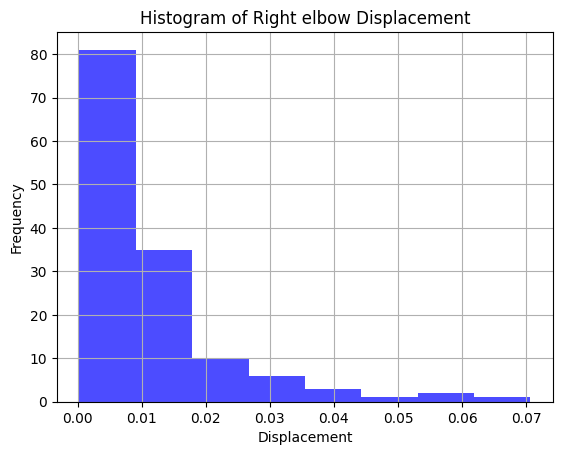

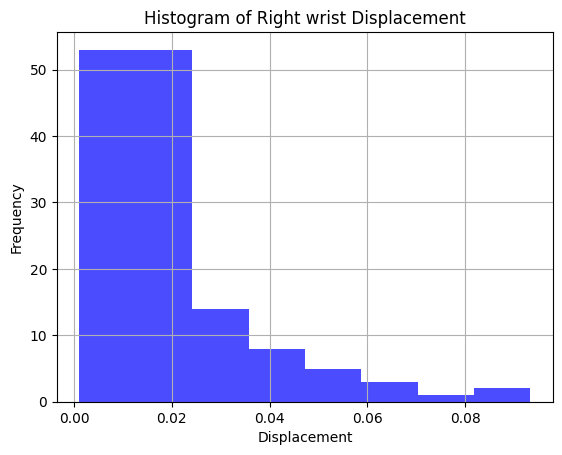

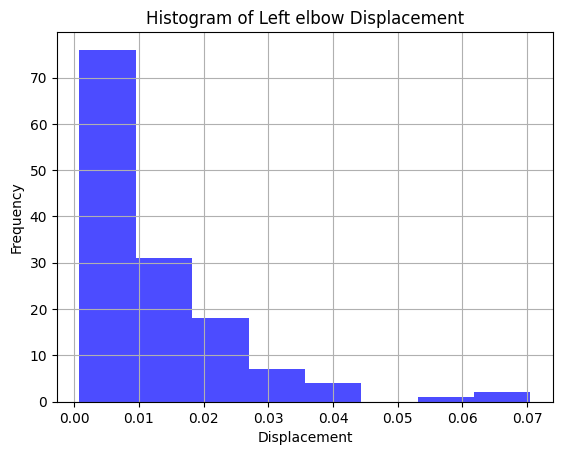

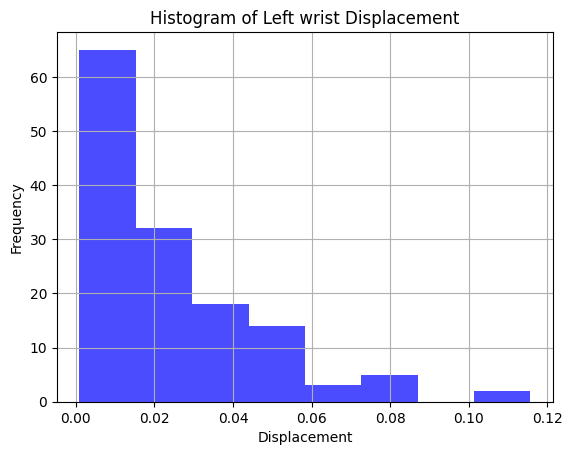

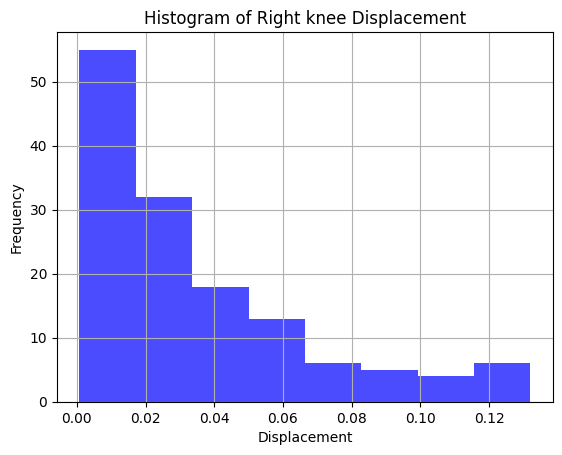

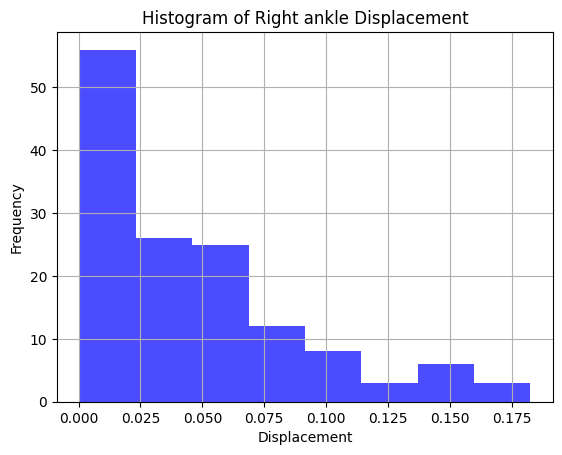

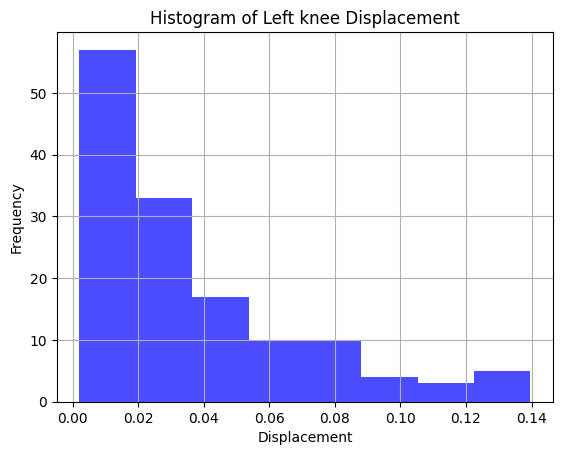

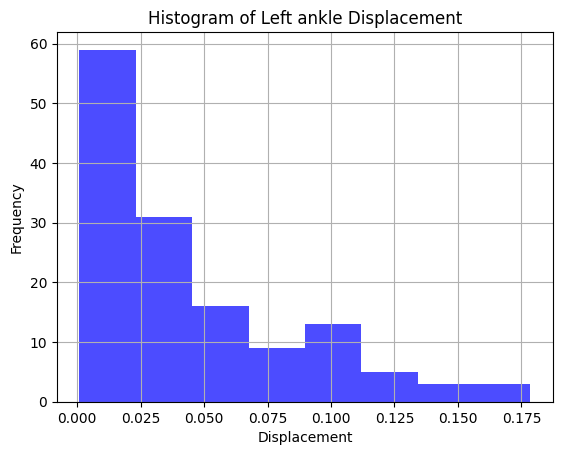

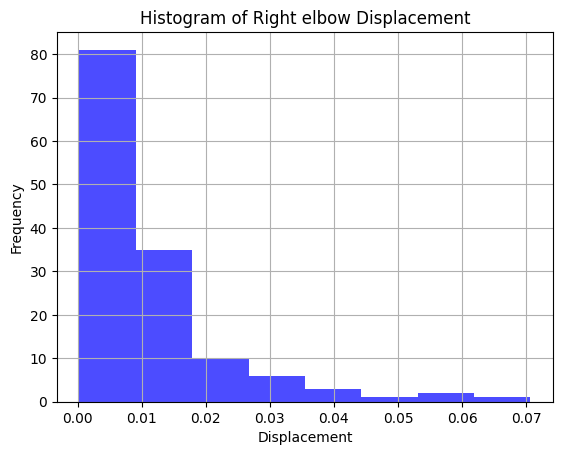

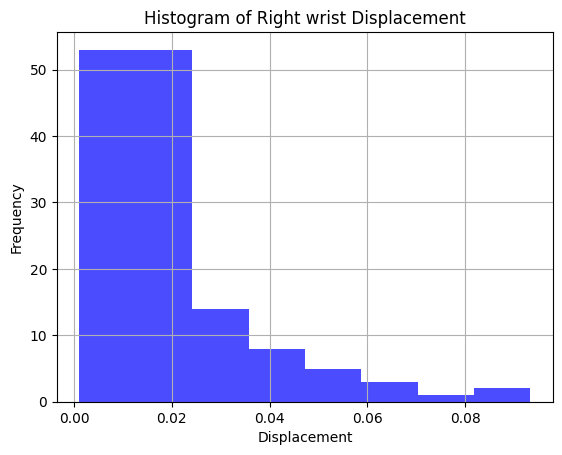

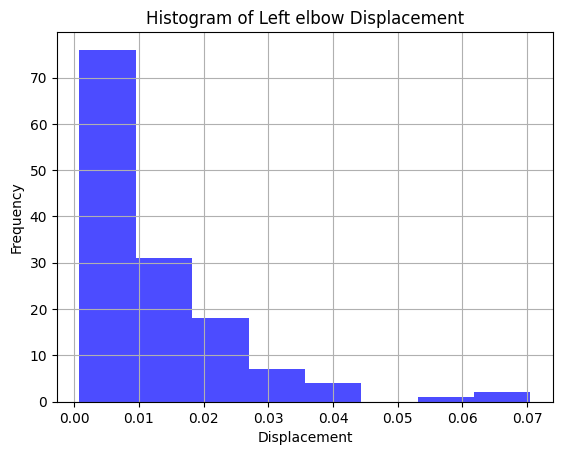

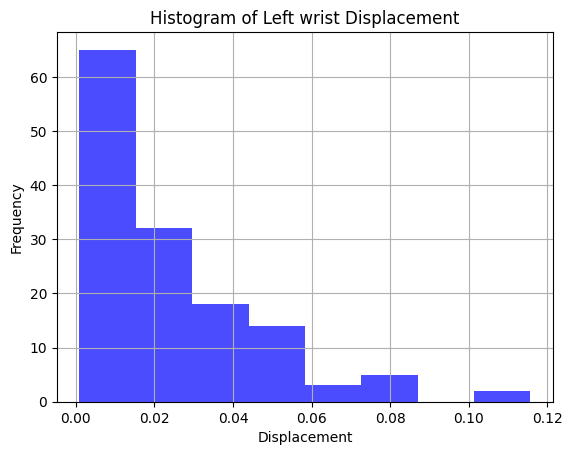

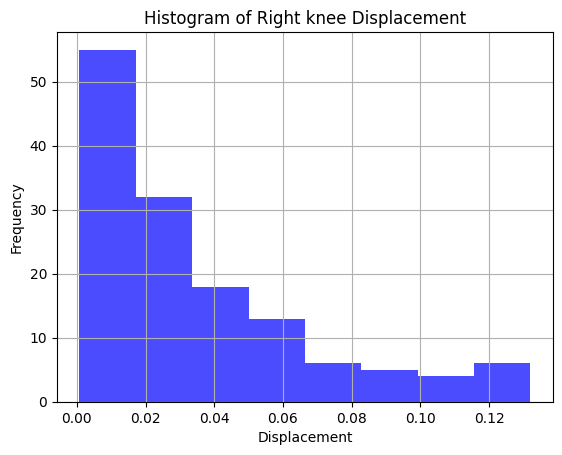

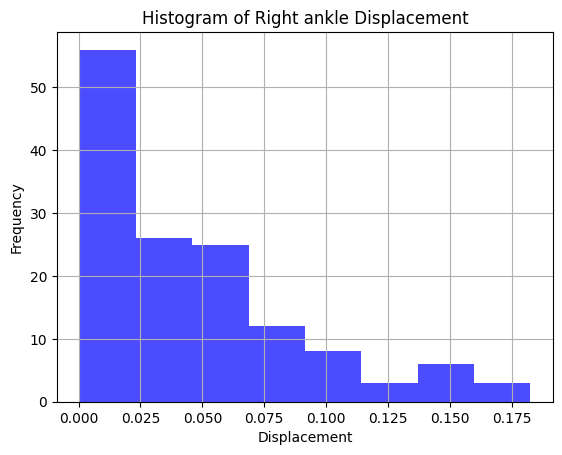

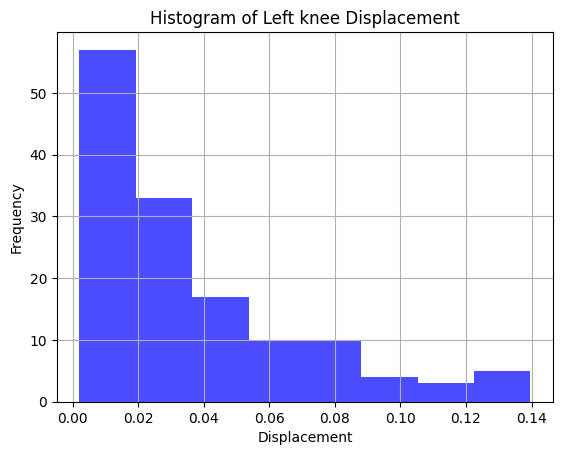

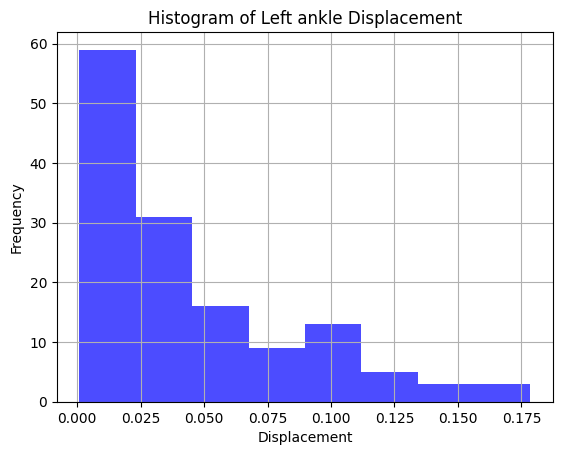

In [15]:
import numpy as np
import cv2 as cv
import mediapipe as mp
import matplotlib.pyplot as plt

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Setup video capture
cap = cv.VideoCapture("./data/infantvideo.mp4")
print("Number of frames:", int(cap.get(cv.CAP_PROP_FRAME_COUNT)))

# Initialize variables to store displacements
displacements = {
    'right_elbow': [],
    'right_wrist': [],
    'left_elbow': [],
    'left_wrist': [],
    'right_knee': [],
    'right_ankle': [],
    'left_knee': [],
    'left_ankle': []
}

# Initialize a dictionary to store the previous joint positions for displacement calculations
prev_landmarks = None

# Frame counter to calculate displacement every 5 frames
frame_interval = 5
frame_count = 0

# Setup Mediapipe Pose instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()

        # Check if the frame was successfully read (False when the video ends)
        if not ret:
            print("End of video or error.")
            break
        
        # Increment the frame counter
        frame_count += 1

        # Recolor image to RGB
        image = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Make detections
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        
        # Only calculate displacement every 5 frames
        if frame_count % frame_interval == 0:
            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                current_frame = int(cap.get(cv.CAP_PROP_POS_FRAMES)) - 1
                
                # Calculate joint displacement for specific joints
                current_positions = {
                    'right_elbow': np.array([landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,
                                             landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]),
                    'right_wrist': np.array([landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,
                                             landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]),
                    'left_elbow': np.array([landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                                            landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]),
                    'left_wrist': np.array([landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,
                                            landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]),
                    'right_knee': np.array([landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,
                                            landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]),
                    'right_ankle': np.array([landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,
                                             landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]),
                    'left_knee': np.array([landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,
                                           landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]),
                    'left_ankle': np.array([landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,
                                            landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y])
                }
                
                # If previous landmarks exist, calculate displacement
                if prev_landmarks is not None:
                    for joint in current_positions.keys():
                        displacement = np.linalg.norm(current_positions[joint] - prev_landmarks[joint])
                        displacements[joint].append(displacement)
                        print(f"Frame {current_frame}: Displacement of {joint.replace('_', ' ').capitalize()} = {displacement:.5f}")
                
                # Update previous landmarks for next frame
                prev_landmarks = current_positions

            except Exception as e:
                print(f"Error processing frame {current_frame}: {e}")
                pass

        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
        
        cv.imshow('Mediapipe Feed', image)
        
        if cv.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()

# Plot histograms for each joint displacement
for joint, displacement in displacements.items():
    plt.figure()
    plt.hist(displacement, bins=8, alpha=0.7, color='blue')
    plt.title(f'Histogram of {joint.replace("_", " ").capitalize()} Displacement')
    plt.xlabel('Displacement')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Save histograms to a file
for joint, displacement in displacements.items():
    plt.figure()
    plt.hist(displacement, bins=8, alpha=0.7, color='blue')
    plt.title(f'Histogram of {joint.replace("_", " ").capitalize()} Displacement')
    plt.xlabel('Displacement')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.savefig(f'{joint}_displacement_histogram.png')

In [65]:
print(BONE_VECTOR[0])
print(BONE_VECTOR.size)
print(normalized_coordinates)

[9.74746723e-312 9.74785658e-312]
1406
[[inf inf]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]


In [7]:
len(landmarks)

33

In [9]:
for lndmrk in mp_pose.PoseLandmark:
    print(lndmrk)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [10]:
landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].visibility

0.9997555613517761

In [11]:
landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value]

x: 0.571585596
y: 0.340536714
z: -0.0850451291
visibility: 0.98265636

In [12]:
landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value]

x: 0.597858369
y: 0.274874121
z: -0.258848727
visibility: 0.979673386